In [154]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2
import os
%matplotlib inline
plt.style.use('ggplot')
pd.set_option('display.max_columns', None)

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

In [3]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler,FunctionTransformer,StandardScaler,OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedKFold,StratifiedShuffleSplit, train_test_split, learning_curve,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score, roc_curve
from imblearn.over_sampling import RandomOverSampler
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
rnd_state = 0

In [4]:
# create a database connection
sqluser = 'maxim'
dbname = 'maxim'
schema_name = 'mimiciii'

In [5]:
# Connect to local postgres version of mimic
connect = psycopg2.connect(dbname=dbname, user=sqluser)
cursor = connect.cursor()
cursor.execute('SET search_path to {}'.format(schema_name))

In [6]:
# Load in the query from file
query='SELECT * FROM OASIS'
oasis = pd.read_sql_query(query, connect)
oasis = oasis.dropna(axis=0)
oasis = oasis.loc[(oasis.urineoutput < 20000) & (oasis.urineoutput > 0) & 
                  (oasis.temp > 30) & (oasis.temp < 45) & (oasis.icustay_age_group == 'adult')]
oasis['preiculos_hours'] = oasis.preiculos.dt.total_seconds()/3600

In [7]:
oasis.head()

,subject_id,hadm_id,icustay_id,icustay_age_group,hospital_expire_flag,icustay_expire_flag,oasis,oasis_prob,age,age_score,preiculos,preiculos_score,gcs,gcs_score,heartrate,heartrate_score,meanbp,meanbp_score,resprate,resprate_score,temp,temp_score,urineoutput,urineoutput_score,mechvent,mechvent_score,electivesurgery,electivesurgery_score,preiculos_hours
0,55973,152234,200001,adult,0,0,42,0.305849,61.0,6,7 days 03:02:12,1,14.0,3.0,134.0,6.0,60.000000,2.0,32.0,6.0,36.388889,2.0,250.0,10.0,0,0,0,6,171.036667
1,27513,163557,200003,adult,0,0,35,0.152892,48.0,3,0 days 02:48:04,3,15.0,0.0,122.0,3.0,179.000000,3.0,39.0,6.0,36.388889,2.0,3652.0,0.0,1,9,0,6,2.801111
2,10950,189514,200006,adult,0,0,32,0.109623,54.0,6,0 days 00:01:14,5,15.0,0.0,73.0,0.0,61.000000,2.0,27.0,1.0,36.166666,2.0,1955.0,1.0,1,9,0,6,0.020556
3,20707,129310,200007,adult,0,0,26,0.054187,43.0,3,0 days 00:01:37,5,15.0,0.0,104.0,1.0,50.666698,3.0,29.0,1.0,36.388889,2.0,1295.0,5.0,0,0,0,6,0.026944
4,29904,129607,200009,adult,0,0,25,0.048012,47.0,3,-1 days +23:49:32,5,15.0,0.0,106.0,1.0,60.000000,2.0,17.5,0.0,34.599998,4.0,1570.0,1.0,1,9,1,0,-0.174444


In [26]:
#X = oasis_adults.drop(['subject_id', 'hadm_id', 'icustay_id', 'icustay_age_group', 'hospital_expire_flag',
#                       'icustay_expire_flag', 'oasis', 'oasis_prob', 'age_prob'], axis=1)
num_features = ['age', 'preiculos_hours', 'gcs', 'heartrate', 'meanbp', 'resprate', 'temp', 'urineoutput']
cat_features = ['mechvent', 'electivesurgery']
X = oasis[num_features + cat_features]
#y = oasis.icustay_expire_flag
y = oasis.hospital_expire_flag
X_train_orig, X_test_orig, y_train, y_test = train_test_split(X, y, test_size=0.2, \
                                                    shuffle=True, stratify=y, random_state=rnd_state)


In [27]:
print('Shape of training set: {}'.format(X_train_orig.shape))
print('Shape of test set: {}'.format(X_test_orig.shape))
print('Number of positives in training set: {}'.format(y_train.sum()))
print('Number of positives in test set: {}'.format(y_test.sum()))

Shape of training set: (38797, 10)
Shape of test set: (9700, 10)
Number of positives in training set: 4480
Number of positives in test set: 1120


In [28]:
num_impute = ('num_impute', SimpleImputer(missing_values=np.nan, strategy='median'))
scale = ('scale', MinMaxScaler())
num_transformer = Pipeline([num_impute, scale])

cat_impute = ('cat_impute', SimpleImputer(strategy='constant', fill_value=2))
#onehot = ('onehot', OneHotEncoder(handle_unknown='error'))
cat_transformer = Pipeline(steps=[cat_impute])

preprocessor = ColumnTransformer(transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)])

X_train = preprocessor.fit_transform(X_train_orig)
X_test = preprocessor.transform(X_test_orig)

In [30]:
from torch.utils import data
class Dataset(data.Dataset):
    
  def __init__(self, X, y):
        'Initialization'
        self.X = X
        self.y = y

  def __len__(self):
        'Denotes the total number of samples'
        return len(self.X)

  def __getitem__(self, index):
        'Generates one sample of data'

        X = self.X[index]
        y = self.y[index]

        return X, y

In [29]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2

In [93]:
train_idx, valid_idx= train_test_split(np.arange(len(y_train.values)),test_size=0.2,shuffle=True,stratify=y_train.values)

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
print(len(train_sampler),len(valid_sampler))
# prepare data loaders
train_loader = torch.utils.data.DataLoader(Dataset(X_train,y_train.values), batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(Dataset(X_train,y_train.values), batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(Dataset(X_test,y_test.values), batch_size=batch_size, 
    num_workers=num_workers)
print(len(train_loader)*20,len(valid_loader)*20)
print(len(train_loader.dataset),len(valid_loader.dataset))

31037 7760
31040 7760
38797 38797


In [249]:
# define the NN architecture
class TwoLayersNet(nn.Module):
    def __init__(self,hidden):
        super(TwoLayersNet, self).__init__()
        self.hidden = hidden
        self.fc1 = nn.Linear(10, self.hidden)
        self.fc2 = nn.Linear(self.hidden, self.hidden)
        self.fc3 = nn.Linear(self.hidden, 1)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        # flatten image input
        x = x.view(-1, 10)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        x = torch.sigmoid(x)
        return x
    
class ThreeLayersNet(nn.Module):
    def __init__(self,hidden):
        super(ThreeLayersNet, self).__init__()
        self.hidden = hidden
        self.fc1 = nn.Linear(10, self.hidden)
        self.fc2 = nn.Linear(self.hidden, self.hidden)
        self.fc3 = nn.Linear(self.hidden, self.hidden)
        self.fc4 = nn.Linear(self.hidden, 1)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        # flatten image input
        x = x.view(-1, 10)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)
        x = torch.sigmoid(x)
        return x

In [204]:
# define the NN architecture
class OneLayerNet(nn.Module):
    def __init__(self,hidden=6):
        super(OneLayerNet, self).__init__()
        self.hidden = hidden
        self.fc1 = nn.Linear(10, self.hidden)
        self.fc2 = nn.Linear(self.hidden, 1)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = x.view(-1, 10)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        x = torch.sigmoid(x)
        return x

In [218]:
def train_per_hidden(n_epochs, hidden,Net):
    # initialize the NN
    model = Net(hidden=hidden)
    criterion = nn.BCELoss(reduction='mean')
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_model = None
    valid_loss_min = np.Inf # set initial "min" to infinity
    conv ={'train':[],'valid':[]}
    for epoch in range(n_epochs):
        # monitor training loss
        train_loss = 0.0
        valid_loss = 0.0

        # train the model #
        model.train() # prep model for training
        for data, target in train_loader:
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data.float())
            # calculate the loss
            target = target.view(-1,1)
            weight=compute_sample_weight(class_weight='balanced', y=target)
            weight=torch.Tensor(weight)
            weight=weight.view(-1,1)
            criterion.weight = weight
            loss = criterion(output.float(), target.float())
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update running training loss
            train_loss += loss.item()#*data.size(0)

        # validate the model #
        model.eval() # prep model for evaluation
        for data, target in valid_loader:
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data.float())
            # calculate the loss
            target = target.view(-1,1)
            weight=compute_sample_weight(class_weight='balanced', y=target)
            weight=torch.Tensor(weight)
            weight=weight.view(-1,1)
            criterion.weight = weight
            loss = criterion(output.float(), target.float())
            # update running validation loss 
            valid_loss += loss.item()#*data.size(0)

        #print('data size:',data.size(0))
        #print('len train loader:',len(train_loader.dataset))
        #print('len valid loader:',len(valid_loader.dataset))
        # print training/validation statistics 
        # calculate average loss over an epoch
        train_loss = train_loss/len(train_loader)
        valid_loss = valid_loss/len(valid_loader)

        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch+1, 
            train_loss,
            valid_loss
            ))
        conv['train'].append(train_loss)
        conv['valid'].append(valid_loss)
        # save model if validation loss has decreased
        if valid_loss <= valid_loss_min:
        #    print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        #    valid_loss_min,
        #    valid_loss))
        #    torch.save(model.state_dict(), 'model.pt')
        #    valid_loss_min = valid_loss
            best_model = model
    return conv, best_model

In [148]:
# number of epochs to train the model
n_epochs = 85
hidden = [6, 12, 24, 48, 96, 124, 248, 496]
res = {'conv':[],'model':[]}
for h in hidden:
    print('Hidden=',h)
    conv,model = train_per_hidden(n_epochs, h,OneLayerNet)   
    res['conv'].append(conv)
    res['model'].append(model)


Hidden= 6
Epoch: 1 	Training Loss: 0.677823 	Validation Loss: 0.661751
Epoch: 2 	Training Loss: 0.647121 	Validation Loss: 0.635216
Epoch: 3 	Training Loss: 0.626748 	Validation Loss: 0.619536
Epoch: 4 	Training Loss: 0.614046 	Validation Loss: 0.608117
Epoch: 5 	Training Loss: 0.610664 	Validation Loss: 0.600937
Epoch: 6 	Training Loss: 0.602543 	Validation Loss: 0.601950
Epoch: 7 	Training Loss: 0.595051 	Validation Loss: 0.591656
Epoch: 8 	Training Loss: 0.596720 	Validation Loss: 0.588667
Epoch: 9 	Training Loss: 0.593751 	Validation Loss: 0.584433
Epoch: 10 	Training Loss: 0.588450 	Validation Loss: 0.582583
Epoch: 11 	Training Loss: 0.582685 	Validation Loss: 0.588211
Epoch: 12 	Training Loss: 0.583383 	Validation Loss: 0.579328
Epoch: 13 	Training Loss: 0.582502 	Validation Loss: 0.576076
Epoch: 14 	Training Loss: 0.580797 	Validation Loss: 0.579976
Epoch: 15 	Training Loss: 0.580263 	Validation Loss: 0.578895
Epoch: 16 	Training Loss: 0.581032 	Validation Loss: 0.574132
Epoch: 

Epoch: 49 	Training Loss: 0.550831 	Validation Loss: 0.551875
Epoch: 50 	Training Loss: 0.549011 	Validation Loss: 0.537966
Epoch: 51 	Training Loss: 0.547683 	Validation Loss: 0.550233
Epoch: 52 	Training Loss: 0.544478 	Validation Loss: 0.538186
Epoch: 53 	Training Loss: 0.543275 	Validation Loss: 0.550672
Epoch: 54 	Training Loss: 0.551694 	Validation Loss: 0.558671
Epoch: 55 	Training Loss: 0.547676 	Validation Loss: 0.555608
Epoch: 56 	Training Loss: 0.547985 	Validation Loss: 0.553260
Epoch: 57 	Training Loss: 0.550697 	Validation Loss: 0.538430
Epoch: 58 	Training Loss: 0.546557 	Validation Loss: 0.539935
Epoch: 59 	Training Loss: 0.546313 	Validation Loss: 0.538490
Epoch: 60 	Training Loss: 0.549679 	Validation Loss: 0.548412
Epoch: 61 	Training Loss: 0.546218 	Validation Loss: 0.533316
Epoch: 62 	Training Loss: 0.542833 	Validation Loss: 0.548102
Epoch: 63 	Training Loss: 0.545820 	Validation Loss: 0.546124
Epoch: 64 	Training Loss: 0.543496 	Validation Loss: 0.536957
Epoch: 6

Epoch: 12 	Training Loss: 0.565166 	Validation Loss: 0.565236
Epoch: 13 	Training Loss: 0.569584 	Validation Loss: 0.560024
Epoch: 14 	Training Loss: 0.562637 	Validation Loss: 0.567123
Epoch: 15 	Training Loss: 0.557324 	Validation Loss: 0.562723
Epoch: 16 	Training Loss: 0.560961 	Validation Loss: 0.558323
Epoch: 17 	Training Loss: 0.557767 	Validation Loss: 0.559513
Epoch: 18 	Training Loss: 0.555469 	Validation Loss: 0.563837
Epoch: 19 	Training Loss: 0.554133 	Validation Loss: 0.559550
Epoch: 20 	Training Loss: 0.556607 	Validation Loss: 0.558249
Epoch: 21 	Training Loss: 0.556260 	Validation Loss: 0.551642
Epoch: 22 	Training Loss: 0.555858 	Validation Loss: 0.550486
Epoch: 23 	Training Loss: 0.552209 	Validation Loss: 0.547363
Epoch: 24 	Training Loss: 0.550641 	Validation Loss: 0.548482
Epoch: 25 	Training Loss: 0.547601 	Validation Loss: 0.552563
Epoch: 26 	Training Loss: 0.547648 	Validation Loss: 0.550685
Epoch: 27 	Training Loss: 0.542082 	Validation Loss: 0.555487
Epoch: 2

Epoch: 60 	Training Loss: 0.522259 	Validation Loss: 0.527510
Epoch: 61 	Training Loss: 0.523078 	Validation Loss: 0.533660
Epoch: 62 	Training Loss: 0.517968 	Validation Loss: 0.520382
Epoch: 63 	Training Loss: 0.513659 	Validation Loss: 0.529401
Epoch: 64 	Training Loss: 0.517346 	Validation Loss: 0.518946
Epoch: 65 	Training Loss: 0.515289 	Validation Loss: 0.531447
Epoch: 66 	Training Loss: 0.521189 	Validation Loss: 0.532811
Epoch: 67 	Training Loss: 0.516753 	Validation Loss: 0.531644
Epoch: 68 	Training Loss: 0.516417 	Validation Loss: 0.525069
Epoch: 69 	Training Loss: 0.514852 	Validation Loss: 0.525535
Epoch: 70 	Training Loss: 0.516272 	Validation Loss: 0.528915
Epoch: 71 	Training Loss: 0.519944 	Validation Loss: 0.529952
Epoch: 72 	Training Loss: 0.510681 	Validation Loss: 0.526157
Epoch: 73 	Training Loss: 0.518948 	Validation Loss: 0.517389
Epoch: 74 	Training Loss: 0.517746 	Validation Loss: 0.526705
Epoch: 75 	Training Loss: 0.513997 	Validation Loss: 0.522309
Epoch: 7

Epoch: 23 	Training Loss: 0.537560 	Validation Loss: 0.556686
Epoch: 24 	Training Loss: 0.540838 	Validation Loss: 0.541138
Epoch: 25 	Training Loss: 0.539845 	Validation Loss: 0.538106
Epoch: 26 	Training Loss: 0.539426 	Validation Loss: 0.541840
Epoch: 27 	Training Loss: 0.532584 	Validation Loss: 0.547034
Epoch: 28 	Training Loss: 0.533655 	Validation Loss: 0.540921
Epoch: 29 	Training Loss: 0.535378 	Validation Loss: 0.542079
Epoch: 30 	Training Loss: 0.533912 	Validation Loss: 0.545383
Epoch: 31 	Training Loss: 0.532662 	Validation Loss: 0.545841
Epoch: 32 	Training Loss: 0.530712 	Validation Loss: 0.544647
Epoch: 33 	Training Loss: 0.536011 	Validation Loss: 0.536520
Epoch: 34 	Training Loss: 0.529635 	Validation Loss: 0.533783
Epoch: 35 	Training Loss: 0.528686 	Validation Loss: 0.541261
Epoch: 36 	Training Loss: 0.529751 	Validation Loss: 0.531365
Epoch: 37 	Training Loss: 0.526762 	Validation Loss: 0.542657
Epoch: 38 	Training Loss: 0.523034 	Validation Loss: 0.542450
Epoch: 3

Epoch: 71 	Training Loss: 0.511165 	Validation Loss: 0.517795
Epoch: 72 	Training Loss: 0.508269 	Validation Loss: 0.513156
Epoch: 73 	Training Loss: 0.511686 	Validation Loss: 0.527411
Epoch: 74 	Training Loss: 0.513588 	Validation Loss: 0.518707
Epoch: 75 	Training Loss: 0.509370 	Validation Loss: 0.520298
Epoch: 76 	Training Loss: 0.511002 	Validation Loss: 0.516378
Epoch: 77 	Training Loss: 0.512551 	Validation Loss: 0.519274
Epoch: 78 	Training Loss: 0.505336 	Validation Loss: 0.523851
Epoch: 79 	Training Loss: 0.512133 	Validation Loss: 0.514644
Epoch: 80 	Training Loss: 0.503402 	Validation Loss: 0.522599
Epoch: 81 	Training Loss: 0.511790 	Validation Loss: 0.510083
Epoch: 82 	Training Loss: 0.511942 	Validation Loss: 0.522034
Epoch: 83 	Training Loss: 0.508703 	Validation Loss: 0.526482
Epoch: 84 	Training Loss: 0.510216 	Validation Loss: 0.530778
Epoch: 85 	Training Loss: 0.510472 	Validation Loss: 0.520402


In [226]:
res

{'conv': [], 'model': []}

TypeError: zip argument #1 must support iteration

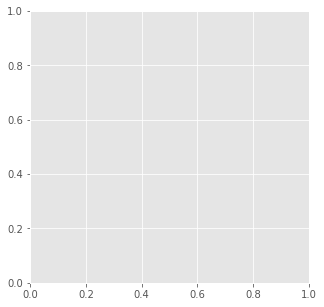

In [225]:
f, axs = plt.subplots(1,1,figsize=(5,5))

for h,conv in zip(hidden,res['conv']):
    plt.plot(conv['train'],label=h)
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.xlabel('Epochs')

plt.savefig('hidden.pdf')

In [224]:
epochs = np.arange(1,85+1)
plt.plot(epochs,res['conv'][0]['train'],label='training')
plt.plot(epochs,res['conv'][0]['valid'],label='validation')
plt.legend(loc='upper right')

IndexError: list index out of range

In [160]:
#model.eval() # prep model for evaluation
def get_predictions(model):
    test_loss = 0.0
    predictions = []
    for data, target in test_loader:
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data.float())
        # calculate the loss
        target = target.view(-1,1)
        weight=compute_sample_weight(class_weight='balanced', y=target)
        weight=torch.Tensor(weight)
        weight=weight.view(-1,1)
        criterion.weight = weight
        loss = criterion(output.float(), target.float())
        # update test loss 
        test_loss += loss.item()#*data.size(0)
        predictions += output.view(1,-1).tolist()[0]
    return predictions

In [167]:
metrics = {'F1':[], 'AUROC': [], 'Precision': [], 'Recall':[]}
for model in res['model']:
    predictions = get_predictions(model)
    binary_predictions = np.round(predictions)
    F1 = f1_score(y_test, binary_predictions)
    auroc = roc_auc_score(y_test, predictions)
    precision = precision_score(y_test, binary_predictions)
    recall = recall_score(y_test, binary_predictions)
    result_str = 'TEST SET f1: {0:.2f} auroc: {1:.2f} precision: {2:.2f} recall: {3:.2f}'.format(F1,auroc,precision,recall)
    metrics['F1'].append(F1)
    metrics['AUROC'].append(auroc)
    metrics['Precision'].append(precision)
    metrics['Recall'].append(recall)
    print(result_str)

TEST SET f1: 0.37 auroc: 0.79 precision: 0.25 recall: 0.72
TEST SET f1: 0.38 auroc: 0.80 precision: 0.26 recall: 0.71
TEST SET f1: 0.38 auroc: 0.80 precision: 0.26 recall: 0.71
TEST SET f1: 0.41 auroc: 0.80 precision: 0.30 recall: 0.66
TEST SET f1: 0.39 auroc: 0.81 precision: 0.27 recall: 0.71
TEST SET f1: 0.40 auroc: 0.81 precision: 0.28 recall: 0.69
TEST SET f1: 0.40 auroc: 0.81 precision: 0.29 recall: 0.67
TEST SET f1: 0.40 auroc: 0.81 precision: 0.28 recall: 0.69


In [236]:
metrics['hidden'] = hidden
df_metrics = pd.DataFrame(metrics)
df_metrics = df_metrics.set_index('hidden')
df_metrics

,F1,AUROC,Precision,Recall
hidden,,,,
24,0.395265,0.811515,0.277657,0.685714


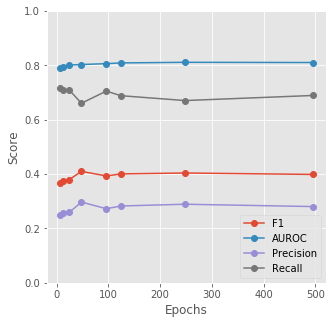

In [196]:
f, axs = plt.subplots(1,1,figsize=(5,5))

for column in df_metrics.columns:
    plt.plot(df_metrics.index,df_metrics[column],'-o',label=column)
plt.legend(loc='lower right')
plt.ylim(0,1)
plt.ylabel('Score')
plt.xlabel('Epochs')

plt.savefig('scores_per_hidden.pdf')

In [243]:
# number of epochs to train the model
n_epochs = 200
hidden = 48
conv,model = train_per_hidden(n_epochs, hidden, OneLayerNet)   

Epoch: 1 	Training Loss: 0.601132 	Validation Loss: 0.589489
Epoch: 2 	Training Loss: 0.569401 	Validation Loss: 0.570598
Epoch: 3 	Training Loss: 0.560587 	Validation Loss: 0.557390
Epoch: 4 	Training Loss: 0.555455 	Validation Loss: 0.558214
Epoch: 5 	Training Loss: 0.546646 	Validation Loss: 0.544277
Epoch: 6 	Training Loss: 0.539506 	Validation Loss: 0.556533
Epoch: 7 	Training Loss: 0.534436 	Validation Loss: 0.553240
Epoch: 8 	Training Loss: 0.535412 	Validation Loss: 0.544638
Epoch: 9 	Training Loss: 0.526727 	Validation Loss: 0.534643
Epoch: 10 	Training Loss: 0.526111 	Validation Loss: 0.529846
Epoch: 11 	Training Loss: 0.528916 	Validation Loss: 0.528614
Epoch: 12 	Training Loss: 0.526114 	Validation Loss: 0.528777
Epoch: 13 	Training Loss: 0.522121 	Validation Loss: 0.525821
Epoch: 14 	Training Loss: 0.520749 	Validation Loss: 0.535473
Epoch: 15 	Training Loss: 0.520031 	Validation Loss: 0.522990
Epoch: 16 	Training Loss: 0.522650 	Validation Loss: 0.522847
Epoch: 17 	Traini

Epoch: 133 	Training Loss: 0.499588 	Validation Loss: 0.517692
Epoch: 134 	Training Loss: 0.498662 	Validation Loss: 0.507533
Epoch: 135 	Training Loss: 0.497352 	Validation Loss: 0.507749
Epoch: 136 	Training Loss: 0.499803 	Validation Loss: 0.517799
Epoch: 137 	Training Loss: 0.498334 	Validation Loss: 0.505404
Epoch: 138 	Training Loss: 0.501081 	Validation Loss: 0.503150
Epoch: 139 	Training Loss: 0.498374 	Validation Loss: 0.515746
Epoch: 140 	Training Loss: 0.499323 	Validation Loss: 0.505064
Epoch: 141 	Training Loss: 0.502853 	Validation Loss: 0.512537
Epoch: 142 	Training Loss: 0.498796 	Validation Loss: 0.508538
Epoch: 143 	Training Loss: 0.505189 	Validation Loss: 0.516167
Epoch: 144 	Training Loss: 0.496821 	Validation Loss: 0.507522
Epoch: 145 	Training Loss: 0.500726 	Validation Loss: 0.518505
Epoch: 146 	Training Loss: 0.496486 	Validation Loss: 0.509935
Epoch: 147 	Training Loss: 0.498625 	Validation Loss: 0.510128
Epoch: 148 	Training Loss: 0.503372 	Validation Loss: 0

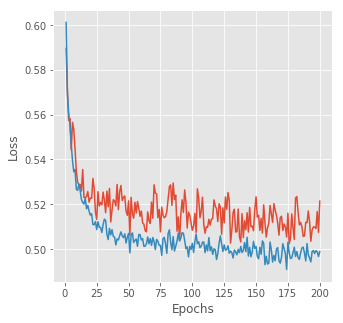

In [244]:
f, axs = plt.subplots(1,1,figsize=(5,5))
epochs = np.arange(1,n_epochs+1)
plt.plot(epochs,conv['valid'])
plt.plot(epochs,conv['train'])
#plt.ylim(0.51,0.6)
#plt.xlim(1,200)
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.savefig('oasis_one_layer1.pdf')

In [245]:
metrics = {'F1':[], 'AUROC': [], 'Precision': [], 'Recall':[]}
for model in [model]:
    predictions = get_predictions(model)
    binary_predictions = np.round(predictions)
    F1 = f1_score(y_test, binary_predictions)
    auroc = roc_auc_score(y_test, predictions)
    precision = precision_score(y_test, binary_predictions)
    recall = recall_score(y_test, binary_predictions)
    result_str = 'TEST SET f1: {0:.2f} auroc: {1:.2f} precision: {2:.2f} recall: {3:.2f}'.format(F1,auroc,precision,recall)
    metrics['F1'].append(F1)
    metrics['AUROC'].append(auroc)
    metrics['Precision'].append(precision)
    metrics['Recall'].append(recall)
    print(result_str)

TEST SET f1: 0.41 auroc: 0.82 precision: 0.30 recall: 0.67


In [246]:
# number of epochs to train the model
n_epochs = 200
hidden = 24
conv,model = train_per_hidden(n_epochs, hidden, TwoLayersNet)   

Epoch: 1 	Training Loss: 0.622450 	Validation Loss: 0.590137
Epoch: 2 	Training Loss: 0.579334 	Validation Loss: 0.571368
Epoch: 3 	Training Loss: 0.557951 	Validation Loss: 0.547764
Epoch: 4 	Training Loss: 0.548840 	Validation Loss: 0.544234
Epoch: 5 	Training Loss: 0.548496 	Validation Loss: 0.540444
Epoch: 6 	Training Loss: 0.534721 	Validation Loss: 0.542996
Epoch: 7 	Training Loss: 0.535509 	Validation Loss: 0.539914
Epoch: 8 	Training Loss: 0.535219 	Validation Loss: 0.533495
Epoch: 9 	Training Loss: 0.529176 	Validation Loss: 0.531756
Epoch: 10 	Training Loss: 0.526756 	Validation Loss: 0.541266
Epoch: 11 	Training Loss: 0.525238 	Validation Loss: 0.529220
Epoch: 12 	Training Loss: 0.528455 	Validation Loss: 0.518501
Epoch: 13 	Training Loss: 0.525139 	Validation Loss: 0.531072
Epoch: 14 	Training Loss: 0.518902 	Validation Loss: 0.529379
Epoch: 15 	Training Loss: 0.518948 	Validation Loss: 0.525907
Epoch: 16 	Training Loss: 0.525116 	Validation Loss: 0.522398
Epoch: 17 	Traini

Epoch: 133 	Training Loss: 0.500691 	Validation Loss: 0.521074
Epoch: 134 	Training Loss: 0.503178 	Validation Loss: 0.512959
Epoch: 135 	Training Loss: 0.507036 	Validation Loss: 0.514525
Epoch: 136 	Training Loss: 0.504884 	Validation Loss: 0.518701
Epoch: 137 	Training Loss: 0.501540 	Validation Loss: 0.521584
Epoch: 138 	Training Loss: 0.498320 	Validation Loss: 0.518504
Epoch: 139 	Training Loss: 0.502122 	Validation Loss: 0.516118
Epoch: 140 	Training Loss: 0.498964 	Validation Loss: 0.513290
Epoch: 141 	Training Loss: 0.498033 	Validation Loss: 0.513079
Epoch: 142 	Training Loss: 0.498303 	Validation Loss: 0.518556
Epoch: 143 	Training Loss: 0.504612 	Validation Loss: 0.515726
Epoch: 144 	Training Loss: 0.498003 	Validation Loss: 0.523990
Epoch: 145 	Training Loss: 0.503602 	Validation Loss: 0.505045
Epoch: 146 	Training Loss: 0.499143 	Validation Loss: 0.518957
Epoch: 147 	Training Loss: 0.504436 	Validation Loss: 0.515952
Epoch: 148 	Training Loss: 0.499812 	Validation Loss: 0

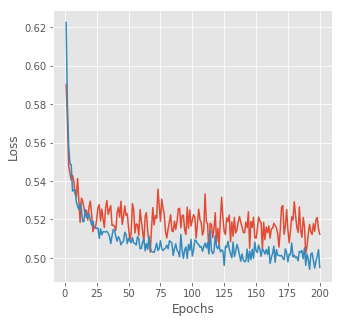

In [247]:
f, axs = plt.subplots(1,1,figsize=(5,5))
epochs = np.arange(1,n_epochs+1)
plt.plot(epochs,conv['valid'])
plt.plot(epochs,conv['train'])
#plt.ylim(0.51,0.6)
#plt.xlim(1,200)
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.savefig('oasis_two_layers.pdf')

In [248]:
metrics = {'F1':[], 'AUROC': [], 'Precision': [], 'Recall':[]}
for model in [model]:
    predictions = get_predictions(model)
    binary_predictions = np.round(predictions)
    F1 = f1_score(y_test, binary_predictions)
    auroc = roc_auc_score(y_test, predictions)
    precision = precision_score(y_test, binary_predictions)
    recall = recall_score(y_test, binary_predictions)
    result_str = 'TEST SET f1: {0:.2f} auroc: {1:.2f} precision: {2:.2f} recall: {3:.2f}'.format(F1,auroc,precision,recall)
    metrics['F1'].append(F1)
    metrics['AUROC'].append(auroc)
    metrics['Precision'].append(precision)
    metrics['Recall'].append(recall)
    print(result_str)

TEST SET f1: 0.41 auroc: 0.82 precision: 0.29 recall: 0.70


In [250]:
# number of epochs to train the model
n_epochs = 200
hidden = 24
conv,model = train_per_hidden(n_epochs, hidden, ThreeLayersNet)   

Epoch: 1 	Training Loss: 0.606393 	Validation Loss: 0.571142
Epoch: 2 	Training Loss: 0.568183 	Validation Loss: 0.546256
Epoch: 3 	Training Loss: 0.560052 	Validation Loss: 0.549070
Epoch: 4 	Training Loss: 0.549799 	Validation Loss: 0.549798
Epoch: 5 	Training Loss: 0.548162 	Validation Loss: 0.539010
Epoch: 6 	Training Loss: 0.539279 	Validation Loss: 0.540573
Epoch: 7 	Training Loss: 0.534357 	Validation Loss: 0.545534
Epoch: 8 	Training Loss: 0.536734 	Validation Loss: 0.532379
Epoch: 9 	Training Loss: 0.536642 	Validation Loss: 0.538739
Epoch: 10 	Training Loss: 0.532080 	Validation Loss: 0.518419
Epoch: 11 	Training Loss: 0.528024 	Validation Loss: 0.548489
Epoch: 12 	Training Loss: 0.530596 	Validation Loss: 0.527755
Epoch: 13 	Training Loss: 0.529742 	Validation Loss: 0.526244
Epoch: 14 	Training Loss: 0.528128 	Validation Loss: 0.523788
Epoch: 15 	Training Loss: 0.526345 	Validation Loss: 0.527761
Epoch: 16 	Training Loss: 0.521080 	Validation Loss: 0.532320
Epoch: 17 	Traini

Epoch: 133 	Training Loss: 0.506599 	Validation Loss: 0.518492
Epoch: 134 	Training Loss: 0.505763 	Validation Loss: 0.524377
Epoch: 135 	Training Loss: 0.507121 	Validation Loss: 0.517655
Epoch: 136 	Training Loss: 0.504976 	Validation Loss: 0.524323
Epoch: 137 	Training Loss: 0.511991 	Validation Loss: 0.523784
Epoch: 138 	Training Loss: 0.502975 	Validation Loss: 0.529049
Epoch: 139 	Training Loss: 0.507773 	Validation Loss: 0.520676
Epoch: 140 	Training Loss: 0.508430 	Validation Loss: 0.520594
Epoch: 141 	Training Loss: 0.505618 	Validation Loss: 0.521719
Epoch: 142 	Training Loss: 0.511516 	Validation Loss: 0.518024
Epoch: 143 	Training Loss: 0.503730 	Validation Loss: 0.520395
Epoch: 144 	Training Loss: 0.507177 	Validation Loss: 0.516536
Epoch: 145 	Training Loss: 0.507274 	Validation Loss: 0.525841
Epoch: 146 	Training Loss: 0.508187 	Validation Loss: 0.540286
Epoch: 147 	Training Loss: 0.506005 	Validation Loss: 0.522583
Epoch: 148 	Training Loss: 0.503039 	Validation Loss: 0

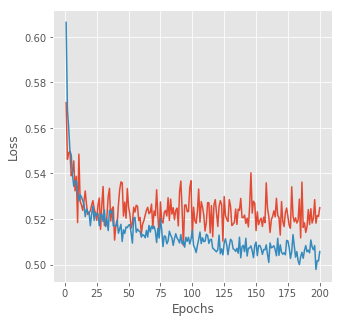

In [251]:
f, axs = plt.subplots(1,1,figsize=(5,5))
epochs = np.arange(1,n_epochs+1)
plt.plot(epochs,conv['valid'])
plt.plot(epochs,conv['train'])
#plt.ylim(0.51,0.6)
#plt.xlim(1,200)
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.savefig('oasis_three_layers.pdf')

In [252]:
metrics = {'F1':[], 'AUROC': [], 'Precision': [], 'Recall':[]}
for model in [model]:
    predictions = get_predictions(model)
    binary_predictions = np.round(predictions)
    F1 = f1_score(y_test, binary_predictions)
    auroc = roc_auc_score(y_test, predictions)
    precision = precision_score(y_test, binary_predictions)
    recall = recall_score(y_test, binary_predictions)
    result_str = 'TEST SET f1: {0:.2f} auroc: {1:.2f} precision: {2:.2f} recall: {3:.2f}'.format(F1,auroc,precision,recall)
    metrics['F1'].append(F1)
    metrics['AUROC'].append(auroc)
    metrics['Precision'].append(precision)
    metrics['Recall'].append(recall)
    print(result_str)

TEST SET f1: 0.38 auroc: 0.82 precision: 0.26 recall: 0.71
